# Run level 2A, 2B and 3 pipelines on IMA data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) December 5th 2017

This notebook demonstrates the execution of the level 2A, 2B and 3 pipelines for IMA data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

http://ssb.stsci.edu/doc/jwst_dev/jwst/pipeline/index.html

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. 

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     111   ()      
  1  SCI           1 ImageHDU        65   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     18   31R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679998,)   uint8   


#### show the last frame of the first integration for each file

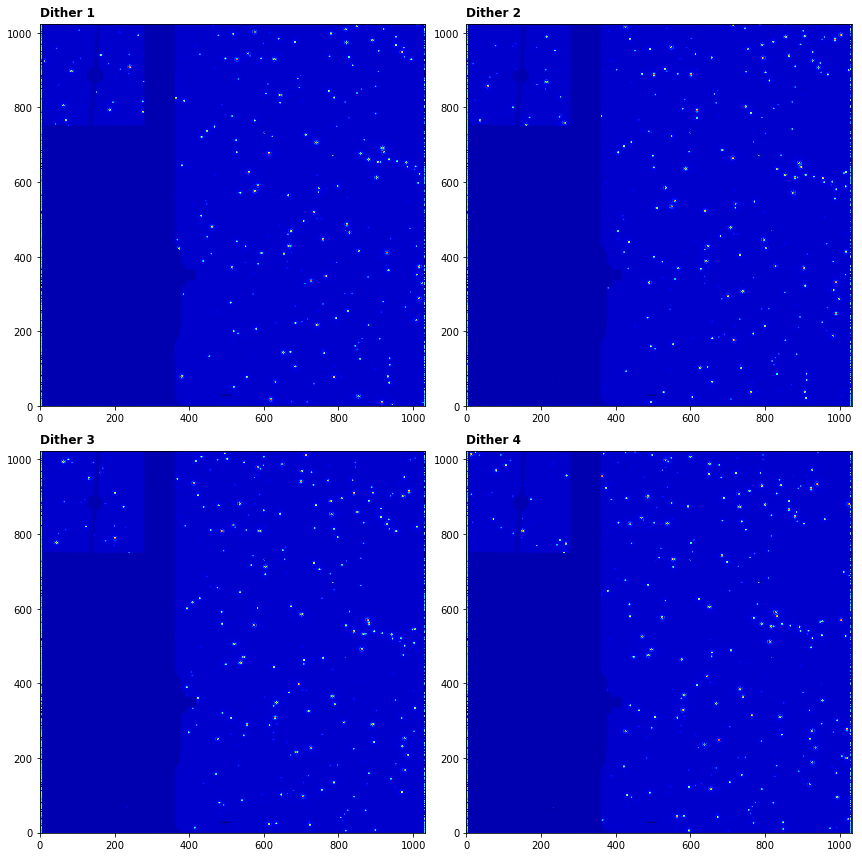

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:
        
        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=1e5))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'


In [6]:
for f in input_files:
    Detector1Pipeline.call(f, save_results=True, output_dir=output_dir)
    

2017-12-12 11:42:16,421 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2017-12-12 11:42:16,423 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2017-12-12 11:42:16,425 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2017-12-12 11:42:16,426 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2017-12-12 11:42:16,428 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-12 11:42:16,429 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-12 11:42:16,430 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-12 11:42:16,432 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-12 11:42:16,433 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-12 11:42:16,434 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-12 11

2017-12-12 11:43:22,654 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2017-12-12 11:43:22,821 - stpipe.Detector1Pipeline.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-12-12 11:43:22,887 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<jwst.datamodels.ramp.RampModel object at 0x11dae6f98>,).
2017-12-12 11:43:22,916 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-12 11:43:22,917 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-12 11:43:22,917 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-12 11:43:22,918 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-12 11:43:22,919 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-12 11:43:23,594 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration
2017-12-12 11:43:24,908 - stpipe.Detector1Pipeline.refpix - INFO - 

2017-12-12 11:47:07,104 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-12 11:47:07,105 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-12 11:47:07,106 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-12 11:47:07,108 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-12 11:47:07,110 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-12-12 11:47:07,112 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-12 11:47:07,113 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-12 11:47:07,115 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-12 11:47:07,116 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2017-12-12 11:47:09,679 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Us

2017-12-12 11:48:09,488 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-12 11:48:09,489 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-12 11:48:09,490 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-12 11:48:10,438 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration
2017-12-12 11:48:11,910 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in
2017-12-12 11:48:12,918 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-12 11:48:13,061 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 11:48:13,063 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-12-12 11:48:13,114 - stpipe.Detector1Pipeline.jump -

2017-12-12 11:51:52,326 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-12 11:51:52,327 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-12 11:51:52,328 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-12 11:51:52,329 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2017-12-12 11:51:54,534 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0058.fits'.
2017-12-12 11:51:54,535 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 11:51:54,535 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ipc_0009.fits'.
2017-12-12 11:51:54,536 - stpipe.Detector1Pipeline - INFO - Pr

2017-12-12 11:52:55,576 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-12 11:52:55,705 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 11:52:55,706 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-12-12 11:52:55,757 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<jwst.datamodels.ramp.RampModel object at 0x2fb04c5c0>,).
2017-12-12 11:52:55,825 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-12-12 11:52:55,876 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-12-12 11:52:55,956 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickka

2017-12-12 11:56:40,372 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 11:56:40,373 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ipc_0009.fits'.
2017-12-12 11:56:40,374 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2017-12-12 11:56:40,375 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits'.
2017-12-12 11:56:40,376 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2017-12-12 11:56:40,376 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri

2017-12-12 11:57:41,690 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-12-12 11:57:41,747 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-12-12 11:57:41,824 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-12-12 11:57:42,899 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2017-12-12 11:57:54,743 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2017-12-12 11:57:54,883 - stpipe.Detector1Pipeline.ramp_fit - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 11:57:54,884 - stpipe.Detector1Pipeline.ramp_fit - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_mi

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [ ]:
from jwst.pipeline import Image2Pipeline
print(Image2Pipeline.__doc__)


    Image2Pipeline: Processes JWST imaging-mode slope data from Level-2a to
    Level-2b.

    Included steps are:
    background_subtraction, assign_wcs, flat_field, photom and resample.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Currently MIRISim is assigning an incorret value of 4 to the wcsaxes keyword in the datamodels. This is due to issues with displaying MIRISim output in applications like ds9. However, the incorrect value will cause an error at the level 3 stage in the resample step, which expects wcsaxes=2 for images. Therefore, we manually set wcsaxes to 2 in the call to Image2Pipeline so it propagates into the cal.fits output.

In [ ]:
for f in level2A_files:
    with datamodels.open(f) as dm:
        dm.meta.wcsinfo.wcsaxes = 2
        Image2Pipeline.call(dm, save_results=True, output_dir=output_dir)
    

2017-12-12 12:01:24,814 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2017-12-12 12:01:24,815 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-12-12 12:01:24,818 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-12-12 12:01:24,819 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-12-12 12:01:24,821 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2017-12-12 12:01:24,823 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2017-12-12 12:01:25,009 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2017-12-12 12:01:25,010 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-12-12 12:01:25,010 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-12-12 12:01:25,011 - stpipe

2017-12-12 12:01:27,679 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<jwst.datamodels.image.ImageModel object at 0x11dbd0940>,).
2017-12-12 12:01:27,836 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2017-12-12 12:01:27,884 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits
2017-12-12 12:01:27,886 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2017-12-12 12:01:27,886 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2017-12-12 12:01:27,887 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2017-12-12 12:01:27,888 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W
2017-12-12 12:01:27,938 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2017-12-12 12:01:27,996 - stpipe.Image2Pipeline.photom - INFO - Pixel area map co

2017-12-12 12:01:31,175 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<jwst.datamodels.image.ImageModel object at 0x176af5278>,).
2017-12-12 12:01:32,378 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019574820990213803 -0.017203108915751983 0.022019581224354073 0.014292260797119732 -0.009299718322555226 0.01659017138452147 -0.01173084259776154 -0.014616536077367334
2017-12-12 12:01:32,378 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2017-12-12 12:01:32,444 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2017-12-12 12:01:32,637 - stpipe.Image2Pipeline.flat_field - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-12-12 12:01:32,638 - stpipe.Image2Pipeline.flat_field - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-12-12 12:01:32,638 - stpipe.Image2Pipeline.flat_field - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/j

2017-12-12 12:01:36,775 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...
2017-12-12 12:01:36,776 - stpipe.Image2Pipeline - INFO - Processing product det_image_3_MIRIMAGE_F1130Wexp1_rate
2017-12-12 12:01:36,777 - stpipe.Image2Pipeline - INFO - Working on input <jwst.datamodels.image.ImageModel object at 0x11e1c64e0> ...
2017-12-12 12:01:36,933 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-12-12 12:01:36,934 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-12-12 12:01:36,935 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-12-12 12:01:36,936 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf'.
2017-12-12 12:01:36,937 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for FILTEROFFSET reference file is '/Users/p

#### Quick check of the pipeline steps applied in the level 2B output. We'll look at the first dither:

In [ ]:
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('photom: %s' % dm.meta.cal_step.photom)


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

In [ ]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

### Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline. We can then combine the dithers with the Image3Pipeline. Note the the image alignment step tweakreg is not working in Build 7.1. Therefore, we skip this step and the associated tweakreg_catalog step. 

The output drizzled image file will be contained in 'ima_dither_i2d.fits' with the source list contained in 'ima_dither_cat.ecsv'. The source detection does not work terrible well at the moment, detecting many spurios sources in the spokes of the PSF and around edges. One can play with the detection parameters to help.

#### create the level 3 association using the asn_from_list tool

In [ ]:
#for n,cal_file in enumerate(cal_files): cal_files[n] = os.path.basename(cal_file)
call(["asn_from_list", "-o", "IMA_asn.json"] + level2B_files + ["--product-name", "ima_dither"])


#### import the level 3 pipeline class and print description

In [ ]:
from jwst.pipeline import Image3Pipeline
print(Image3Pipeline.__doc__)

#### run pipeline

In [ ]:
dm_3_container = datamodels.ModelContainer("IMA_asn.json")

Image3Pipeline.call(dm_3_container, save_results=True, steps={'source_catalog':{'snr_threshold':10.0, 'deblend':'True'}})

In [ ]:
# move the Image3Pipeline output to the output_dir
try:
    for file in glob.glob('*crf.fits'): shutil.move(file,os.path.join(output_dir,file))
except:
    pass
try:
    shutil.move('ima_dither_i2d.fits',os.path.join(output_dir,'ima_dither_i2d.fits'))
except:
    pass
try:
    shutil.move('IMA_asn.json',os.path.join(output_dir,'IMA_asn.json'))
except:
    pass
try:
    shutil.move('ima_dither_cat.ecsv',os.path.join(output_dir,'ima_dither_cat.ecsv'))
except:
    pass

#### plot the drizzled file

In [ ]:
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

#### look at the source list 

In [ ]:
from astropy.table import Table

my_catalog = os.path.join(output_dir,'ima_dither_cat.ecsv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print(sources.columns)    # print all available column names
print()
sources['id', 'xcentroid', 'ycentroid', 'sky_centroid', 'abmag'].pprint(max_width=200)

#### plot the source list over the drizzled image

In [ ]:
from astropy.table import Table
from photutils import CircularAperture

# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=10.)

# image
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
apertures.plot(color='white', lw=2.0, alpha=0.5)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()